# Image Classification

## Importing Libraries

In [1]:
#Importing os, glob and cv2 to read and import data
import os
import cv2
import glob

#Importing tqdm for the progress bar
from tqdm import tqdm

#Importing numpy and pandas for data manipulation
import numpy as np
import pandas as pd

#Import random for randomness
import random

#Importing matplotlib.pyplot for visual representation
import matplotlib.pyplot as plt

#Importing One Hot Encoder:
from sklearn.preprocessing import OneHotEncoder

#Importing train test split
from sklearn.model_selection import train_test_split

#Setting seed
seed = 5901

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Conv2D,Add
from tensorflow.keras.layers import SeparableConv2D,ReLU
from tensorflow.keras.layers import BatchNormalization,MaxPool2D
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [4]:
# !pip install git+https://github.com/rcmalli/keras-squeezenet.git
# from keras_squeezenet import SqueezeNet

In [5]:
import time

## Loading Data

In [6]:
#Initializing the path of the datasets
trainPath = "/kaggle/input/plant-seedlings-classification-cs429529/train"
testPath = "/kaggle/input/plant-seedlings-classification-cs429529/test"

In [7]:
def loadData(path):
    X = []
    Y = []
    for y in os.listdir(path):
        if y != '.DS_Store':
            for img in glob.glob(path + "/" + y +"/*.png"):
                #reads the image as Blue-Green-Red
                image = cv2.imread(img)
                #converts the image to red-green-blue
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (70, 70))
                X.append(image)
                Y.append(y)
    return X, Y

In [8]:
X,Y = loadData(trainPath)

## Data Exploration

Showing samples

In [9]:
def plotData(X, Y, col=4):
    label = set(Y)
    n = len(label)
    row = n // col
    if np.mod(n, col) != 0:
        row += 1
    fig, axs = plt.subplots(row, col, figsize=(10, 10))
    i = 0
    for y in label:
        index = random.choice(np.where(np.array(Y) == y)[0])
        axs[i // col, i % col].imshow(X[index])
        axs[i // col, i % col].axis("off")
        axs[i // col, i % col].set_title(y)
        i += 1
    for j in range(i, row * col):
        axs[j // col, j % col].axis("off")
    plt.show()

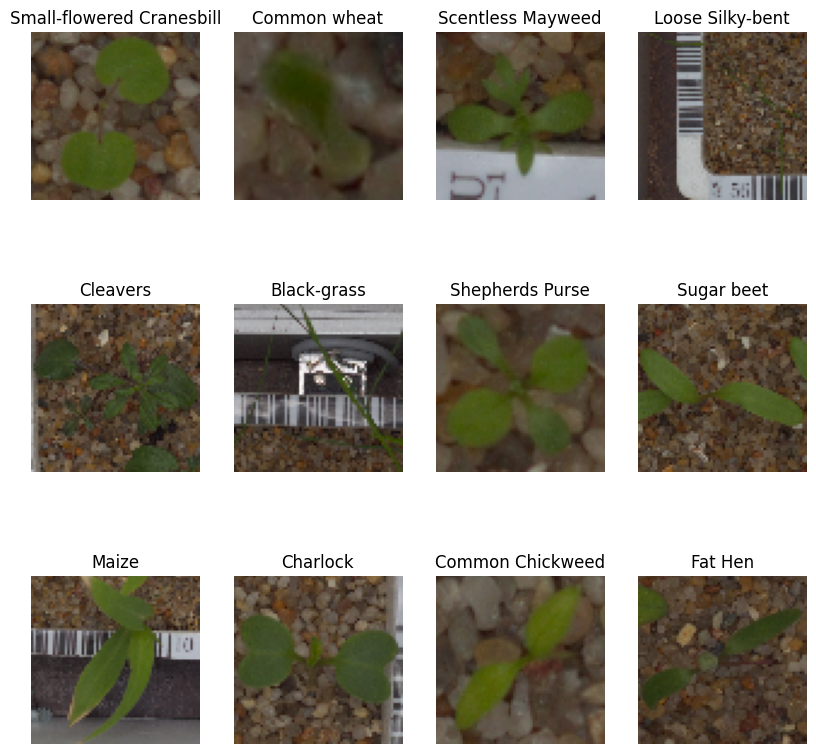

In [10]:
plotData(X, Y)

Data distribution per class

In [11]:
def classPlot(Y):
    pd.DataFrame(Y)[0].value_counts().plot(kind='bar')

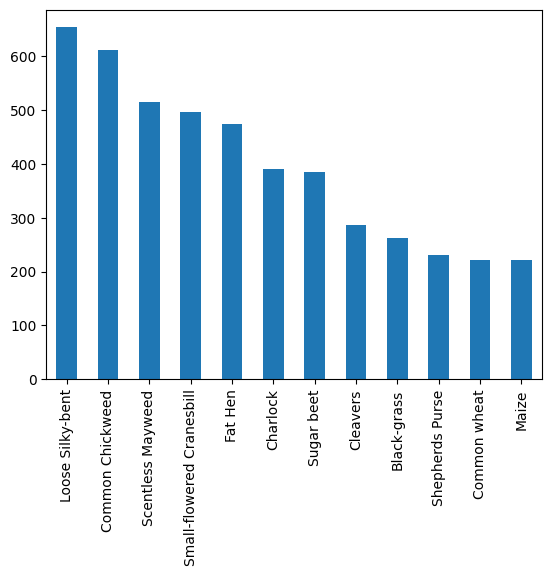

In [12]:
classPlot(Y)

## Preprocessing

### Utility functions

In [13]:
#Perform Gaussian Blur to reduce Noise
def gaussianBlur(img):
    return cv2.GaussianBlur(img, (5,5), 0)

#Convert Image to HSV (Hue - Saturation - Value) to represent the color range better for masking
def HSV(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

#Creating boolean mask to segment the leaves in the image
def Mask(img):
    lGreen = (20, 40, 50)
    uGreen = (75, 255, 255)
    mask = cv2.inRange(img, lGreen, uGreen)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask > 0

def applyMask(img, showImg=False):
    
    gImg = gaussianBlur(img)
    hsvImg = HSV(gImg)
    amImg = np.zeros_like(img, np.uint8)
    mask = Mask(hsvImg)
    
    #Image Segmentation
    amImg[mask] = img[mask]
    
    if showImg:
        plt.subplot(2, 3, 1); plt.imshow(img); plt.title("Orginal Image")
        plt.subplot(2, 3, 2); plt.imshow(gImg); plt.title("Blur Image")
        plt.subplot(2, 3, 3); plt.imshow(hsvImg); plt.title("HSV Image")
        plt.subplot(2, 3, 4); plt.imshow(mask); plt.title("Mask")
        plt.subplot(2, 3, 5); plt.imshow(amImg); plt.title("Segmented Image")
    
    return amImg

#Normalizing the value to be between 0 to 1
def norm(data):
    return data/255

#One hot encoding the Class Values:
def oneHot(Y):
    Y = np.array(Y).reshape(-1, 1)
    encoder = OneHotEncoder()
    return encoder.fit_transform(Y), encoder

def decode(encoder, yPred):
    return np.array(encoder.categories_[0])[yPred]

### Testing the Masking Process

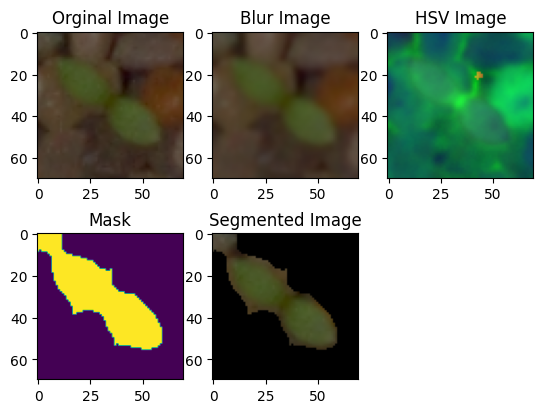

In [14]:
sample = applyMask(X[10], True)

### Applying the Preprocessing to the Data

In [15]:
def preprocessing(X, Y):
    ppX = []
    for img in X:
        ppX.append(applyMask(img))
    ppX = np.array(ppX)
    normX = norm(ppX)
    ohY, encoder = oneHot(Y)
    return normX, ohY.toarray(), encoder

In [16]:
ppX, ppY, encoder = preprocessing(X, Y)

### Train/Test Split

In [17]:
trainX, valX, trainY, valY = train_test_split(ppX, ppY, test_size=0.33, stratify = ppY, shuffle=True)

### Data Augmentation

In [18]:
datagen = ImageDataGenerator(
        rotation_range=180,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically 
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True  # randomly flip images vertically
    )  
datagen.fit(trainX)

## Testing the Model

### Defining the Model Architecture

In [19]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [20]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(70, 70, 3))

94765736/94765736 [==============================] - 4s 0us/step


In [22]:
# model code

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(12, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 70, 70, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 76, 76, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 35, 35, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 35, 35, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

In [23]:
for layer in base_model.layers:
    layer.trainable = False

In [26]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
# Setting checkpoints
lrr = ReduceLROnPlateau(monitor='val_acc',
                        patience=5,
                        verbose=1,
                        factor=0.4,
                        min_lr=0.00001)

filepath="./weights.best.hdf5"
checkpoint_best = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

filepath="./weights.last_auto4.hdf5"
checkpoints_full = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint_best, lrr, checkpoints_full]

In [28]:
hist = model.fit(datagen.flow(trainX, trainY, batch_size=75), epochs=100, validation_data=(valX, valY), callbacks=callbacks_list)

Epoch 1/100
43/43 [==============================] - 15s 165ms/step - loss: 2.5134 - accuracy: 0.1125 - val_loss: 2.4222 - val_accuracy: 0.1358 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 5s 123ms/step - loss: 2.4402 - accuracy: 0.1204 - val_loss: 2.4080 - val_accuracy: 0.1403 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 6s 133ms/step - loss: 2.4200 - accuracy: 0.1449 - val_loss: 2.4048 - val_accuracy: 0.1282 - lr: 0.0010
Epoch 4/100
43/43 [==============================] - 5s 124ms/step - loss: 2.4171 - accuracy: 0.1464 - val_loss: 2.4001 - val_accuracy: 0.1773 - lr: 0.0010
Epoch 5/100
43/43 [==============================] - 5s 121ms/step - loss: 2.4130 - accuracy: 0.1486 - val_loss: 2.3968 - val_accuracy: 0.1703 - lr: 0.0010
Epoch 6/100
43/43 [==============================] - 6s 137ms/step - loss: 2.4144 - accuracy: 0.1534 - val_loss: 2.3993 - val_accuracy: 0.1282 - lr: 0.0010
Epoch 7/100
43/43 [==============================] - 5s 120ms/s

## Evaluating the Model

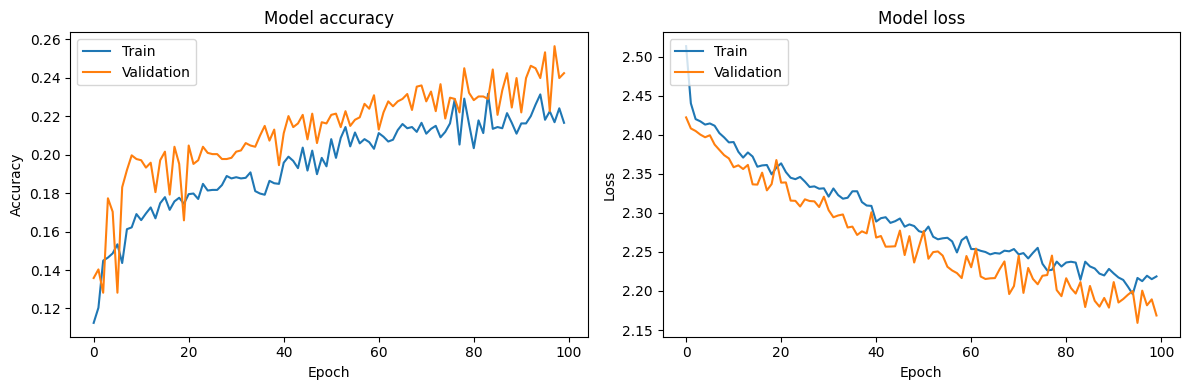

In [30]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [31]:
valLoss, valAcc = model.evaluate(valX, valY, verbose=2)

print(f'Test loss: {valLoss}')
print(f'Test accuracy: {valAcc}')

49/49 - 1s - loss: 2.1686 - accuracy: 0.2423 - 874ms/epoch - 18ms/step
Test loss: 2.1686036586761475
Test accuracy: 0.24234694242477417


In [32]:
predV =  np.argmax(model.predict(valX), axis=1)

49/49 [==============================] - 2s 15ms/step


In [33]:
from sklearn.metrics import classification_report

valYC = decode(encoder, np.argmax(valY, axis=1))
predVC = decode(encoder, predV)

print(classification_report(valYC, predVC))

                           precision    recall  f1-score   support

              Black-grass       0.00      0.00      0.00        87
                 Charlock       0.25      0.29      0.27       129
                 Cleavers       0.00      0.00      0.00        95
         Common Chickweed       0.17      0.43      0.24       201
             Common wheat       0.00      0.00      0.00        73
                  Fat Hen       0.27      0.27      0.27       157
         Loose Silky-bent       0.42      0.51      0.46       216
                    Maize       0.00      0.00      0.00        73
        Scentless Mayweed       0.36      0.03      0.05       170
          Shepherds Purse       0.00      0.00      0.00        76
Small-flowered Cranesbill       0.21      0.57      0.30       164
               Sugar beet       0.62      0.04      0.07       127

                 accuracy                           0.24      1568
                macro avg       0.19      0.18      0.14    

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
def loadTestData(path):
    X = []
    fName = []
    for img in glob.glob(path + "/*.png"):
        #reads the image as Blue-Green-Red
        image = cv2.imread(img)
        #converts the image to red-green-blue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (70, 70))
        X.append(image)
        fName.append(img.split("/")[-1])
    return X, fName

In [ ]:
testD, tName = loadTestData(testPath)

In [ ]:
def preprocessingTest(X):
    ppX = []
    for img in X:
        ppX.append(applyMask(img))
    ppX = np.array(ppX)
    normX = norm(ppX)
    return normX

In [ ]:
ppTD = preprocessingTest(testD)

In [ ]:
yPred =  np.argmax(model.predict(ppTD), axis=1)

In [ ]:
predictions = pd.DataFrame({
    "file": tName,
    "species": decode(encoder, yPred)
})

predictions.head()

In [ ]:
predictions.to_csv("predictions.csv", index=False)